In [1]:
### IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')
from scipy.sparse import csr_matrix

In [2]:
### LOADING THE BOOKS, RATINGS AND USERS DATA

books = pd.read_csv('BX-Books.csv', sep = ';', on_bad_lines='skip', encoding = 'latin-1', dtype={3: str})
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BX-Users.csv', sep = ';', on_bad_lines = 'skip', encoding = 'latin-1', dtype={3: str})
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep = ';', on_bad_lines = 'skip', encoding = 'latin-1', dtype={3: str})
ratings.columns = ['userID', 'ISBN', 'bookRating']

#### EXPLORATORY DATA ANALYSIS

In [3]:
print(ratings.shape)
print(list(ratings.columns))

(1149780, 3)
['userID', 'ISBN', 'bookRating']


Text(0, 0.5, 'Count')

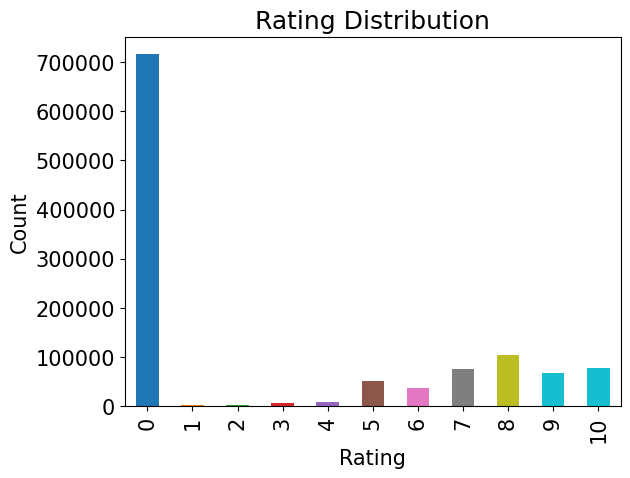

In [4]:
plt.rc('font', size = 15)
ratings_count = ratings.bookRating.value_counts(sort=False)


ratings_count = ratings_count.sort_index()


ratings_count.plot(kind='bar', color=plt.cm.tab10(range(len(ratings_count))))


plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

In [5]:
print(books.shape)
print(list(books.columns))

(271360, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [6]:
print(users.shape)
print(list(users.columns))

(278858, 3)
['userID', 'Location', 'Age']


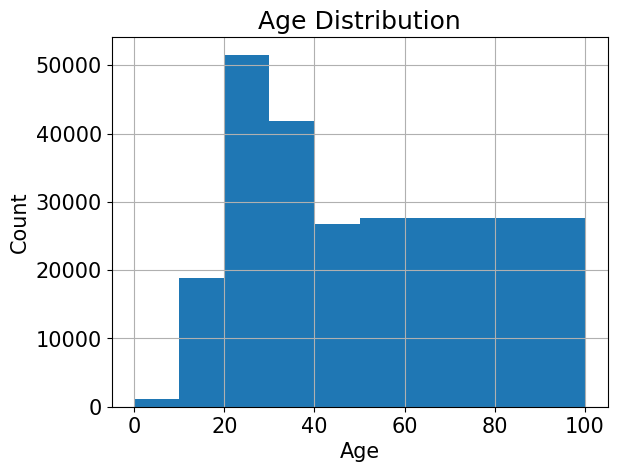

In [7]:
users.Age.hist(bins = [0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [8]:
rating_count = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
rating_count.sort_values('bookRating', ascending = False).head()

,bookRating
ISBN,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723


In [9]:
most_rated_books = pd.DataFrame(['0971880107', '0316666343', '0385504209', '0060928336', '0312195516'], index = np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, books, on = 'ISBN')
most_rated_books_summary

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
1,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
2,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
3,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
4,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...


#### 1. RECOMMENDATIONS OF BOOKS BASED ON CORRELATIONS

In [10]:
avg_rating = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].mean())
avg_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
avg_rating.sort_values('ratingCount', ascending = False).head()

,bookRating,ratingCount
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


#### Users with less than 200 ratings and Books with less than 100 ratings are excluded, a threshold fixed 
#### for statistical significance.

In [11]:
count_1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(count_1[count_1 >= 200].index)]
count_2 = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(count_2[count_2 >= 100].index)]

In [12]:
ratings_pivot = ratings.pivot(index = 'userID', columns = 'ISBN').bookRating
userID = ratings_pivot.index
ISBN = ratings_pivot.columns
print(ratings_pivot.shape)
ratings_pivot.head()


(905, 207699)


ISBN,0330299891,0375404120,0586045007,9022906116,9032803328,9044922564,9044922572,9044922718,9044923161,904492401X,...,UNGRANDHOMMED,X000000000,"YOUTELLEM,AND",ZR903CX0003,"\0432534220\""""","\2842053052\""""",b00005wz75,cn108465,cn113107,Ô½crosoft
userID,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
bones_rating = ratings_pivot['0316666343']
similar_to_bones = ratings_pivot.corrwith(bones_rating)
corr_bones = pd.DataFrame(similar_to_bones, columns = ['pearsonR'])
corr_bones.dropna(inplace = True)
corr_summary = corr_bones.join(avg_rating['ratingCount'])
corr_summary[corr_summary['ratingCount'] >= 300].sort_values('pearsonR', ascending = False).head(10)

,pearsonR,ratingCount
ISBN,,
0316666343,1.000000,1295
0312291639,0.471872,354
0316601950,0.434248,568
0446610038,0.429712,391
0446672211,0.421478,585
0385265700,0.351635,319
0345342968,0.316922,321
0060930535,0.309860,494
0375707972,0.308145,354


In [14]:
books_corr_to_bones = pd.DataFrame(['0312291639', '0316601950', '0446610038', '0446672211',	'0385265700', '0345342968',	'0060930535', 
                                    '0375707972', '0684872153'], index = np.arange(9), columns = ['ISBN'])
corr_books = pd.merge(books_corr_to_bones, books, on = 'ISBN')
corr_books


,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0312291639,The Nanny Diaries: A Novel,Emma McLaughlin,2003,St. Martin's Griffin,http://images.amazon.com/images/P/0312291639.0...,http://images.amazon.com/images/P/0312291639.0...,http://images.amazon.com/images/P/0312291639.0...
1,0316601950,The Pilot's Wife : A Novel,Anita Shreve,1999,Back Bay Books,http://images.amazon.com/images/P/0316601950.0...,http://images.amazon.com/images/P/0316601950.0...,http://images.amazon.com/images/P/0316601950.0...
2,0446610038,1st to Die: A Novel,James Patterson,2002,Warner Vision,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...
3,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...
4,0385265700,The Book of Ruth (Oprah's Book Club (Paperback)),Jane Hamilton,1990,Anchor,http://images.amazon.com/images/P/0385265700.0...,http://images.amazon.com/images/P/0385265700.0...,http://images.amazon.com/images/P/0385265700.0...
5,0345342968,Fahrenheit 451,RAY BRADBURY,1987,Del Rey,http://images.amazon.com/images/P/0345342968.0...,http://images.amazon.com/images/P/0345342968.0...,http://images.amazon.com/images/P/0345342968.0...
6,0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...
7,0375707972,The Reader,Bernhard Schlink,1999,Vintage Books USA,http://images.amazon.com/images/P/0375707972.0...,http://images.amazon.com/images/P/0375707972.0...,http://images.amazon.com/images/P/0375707972.0...
8,0684872153,Angela's Ashes (MMP) : A Memoir,Frank McCourt,1999,Scribner,http://images.amazon.com/images/P/0684872153.0...,http://images.amazon.com/images/P/0684872153.0...,http://images.amazon.com/images/P/0684872153.0...


#### 2. RECOMMENDATIONS OF BOOKS USING KNN 

In [15]:
combine_book_rating = pd.merge(ratings, books, on = 'ISBN')
columns = ['yearOfPublication', 'publisher','bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis = 1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,277427,0026217457,0,Vegetarian Times Complete Cookbook
2,277427,003008685X,8,Pioneers
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)"
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels)


In [16]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])
book_ratingCount = (combine_book_rating.groupby(by = ['bookTitle'])['bookRating'].count().
                    reset_index().rename(columns = {'bookRating':'totalRatingCount'})
                    [['bookTitle', 'totalRatingCount']])
book_ratingCount.head()


,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [17]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', 
                                                         how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,7
2,277427,003008685X,8,Pioneers,1
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",1
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),13


In [18]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()


,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
13,277427,0060930535,0,The Poisonwood Bible: A Novel,133
15,277427,0060934417,0,Bel Canto: A Novel,108
18,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,108
24,277427,006440188X,0,The Secret Garden,79


In [19]:
rating_popular_book.shape

(62149, 5)

##### Filtering Users in US and Canada

In [20]:
combined = rating_popular_book.merge(users, left_on = 'userID', right_on = 'userID', how = 'left')
us_canada_user_rating = combined[combined['Location'].str.contains('usa|canada')]
us_canada_user_rating = us_canada_user_rating.drop('Age', axis = 1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"gilbert, arizona, usa"
1,277427,0060930535,0,The Poisonwood Bible: A Novel,133,"gilbert, arizona, usa"
2,277427,0060934417,0,Bel Canto: A Novel,108,"gilbert, arizona, usa"
3,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,108,"gilbert, arizona, usa"
4,277427,006440188X,0,The Secret Garden,79,"gilbert, arizona, usa"


In [21]:
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
us_canada_user_pivot_rating = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_pivot_rating.values)
us_canada_user_pivot_rating.head()

userID,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,271448,271705,273979,274061,274308,274808,275970,277427,277639,278418
bookTitle,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0


In [22]:
query_index = np.random.choice(us_canada_user_pivot_rating.shape[0])

In [23]:
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [24]:
us_canada_user_pivot_rating.iloc[query_index, :].values.reshape(1, -1)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [25]:
print(query_index)
distances, indices = knn.kneighbors(us_canada_user_pivot_rating.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)

86


In [26]:
us_canada_user_pivot_rating.index[query_index]

'Blood Work'

In [27]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_pivot_rating.index[query_index]))
    else:
        print('{0}:{1}, with distance of {2}:'.format(i, us_canada_user_pivot_rating.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Blood Work:

1:Neuromancer (Remembering Tomorrow), with distance of 0.7040194535140183:
2:A Darkness More Than Night, with distance of 0.7156708650466963:
3:The Door to December, with distance of 0.7330883179147667:
4:Foucault's Pendulum, with distance of 0.7480740648100419:
5:Envy, with distance of 0.7606145004212511:
